In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt


# Função de ativação: Sinal
def sinal(x):
    u = x.item(0)
    if x > 0:
        return 1;
    return -1;


# Função de ativação: Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Derivada da função Sigmoid
def derivada_sigmoid(x):
    return x * (1 - x)


# Função de ativação: ReLU
def relu(x):
    return np.maximum(0, x)


# Derivada de ReLU
def derivada_relu(x):
    return np.where(x > 0, 1, 0)


# Função de perda: Entropia Cruzada Binária: calcula a diferença entre os valores reais e previstos no contexto de classificação binária.
def entropia_cruzada_binaria(y_verdadeiro, y_predito):

    y_predito = np.clip(y_predito, 1e-15, 1 - 1e-15)  # Evitar valores fora da faixa (0, 1)
    return -np.mean(y_verdadeiro * np.log(y_predito) + (1 - y_verdadeiro) * np.log(1 - y_predito))


# Função de perda: Erro Quadrático Médio (EQM)
def eqm(y_verdadeiro, y_predito):
    return np.mean((y_verdadeiro - y_predito) ** 2)


# Estrutura da Rede Neural
class ClassificacaoBinaria:

    def __init__(self, entrada_tamanho, oculto_tamanho, saida_tamanho, taxa_aprendizado):

        # Número de atributos (colunas de entrada).
        self.entrada_tamanho = entrada_tamanho
        # Número de neurônios na camada oculta.
        self.oculto_tamanho = oculto_tamanho
        # Número de classes ou saídas (1 neste caso para classificação binária).
        self.saida_tamanho = saida_tamanho
        # Taxa para o gradiente descendente.
        self.taxa_aprendizado = taxa_aprendizado

        # Inicialização dos pesos e vieses com valores aleatórios pequenos
        self.pesos_entrada_oculto = np.random.randn(entrada_tamanho, oculto_tamanho) * 0.01
        self.vies_oculto = np.zeros((1, oculto_tamanho))
        self.pesos_oculto_saida = np.random.randn(oculto_tamanho, saida_tamanho) * 0.01
        self.vies_saida = np.zeros((1, saida_tamanho))


    # Calcula a saída da rede. Recebe como parâmetro o conjunto de dados de entrada.
    def propagacao_frente(self, entrada):

        # CAMADA 1: Propagação da camada de entrada para a oculta
        self.entrada_oculto = np.dot( entrada, self.pesos_entrada_oculto ) + self.vies_oculto
        self.saida_oculto = sigmoid( self.entrada_oculto )

        # CAMADA 2: Propagação da camada oculta para a camada de saída
        self.entrada_saida = np.dot( self.saida_oculto, self.pesos_oculto_saida ) + self.vies_saida
        self.saida_final = sigmoid( self.entrada_saida )

        return self.saida_final


    # Executa retropropagação (backpropagation) para atualizar os pesos.
    # - entrada: dados de entrada.
    # - y_verdadeiro: valores reais
    # - saida: saída gerada pela rede.
    def retropropagacao(self, entrada, y_verdadeiro, saida):

        # Calcula o erro da saída
        erro = y_verdadeiro - saida

        # Calcula o gradiente na camada de saída
        gradiente_saida = erro * derivada_sigmoid(saida)

        # Calcula o erro e o gradiente na camada oculta
        erro_oculto = np.dot( gradiente_saida, self.pesos_oculto_saida.T )
        gradiente_oculto = erro_oculto * derivada_sigmoid(self.saida_oculto)

        # Atualização dos pesos e vieses entre a camada oculta e a saída
        gradiente_pesos_saida = np.dot( self.saida_oculto.T, gradiente_saida )  # Matriz de ajustes para pesos
        gradiente_vies_saida = np.sum( gradiente_saida, axis=0, keepdims=True )  # Vetor de ajustes para vieses
        self.pesos_oculto_saida += gradiente_pesos_saida * self.taxa_aprendizado
        self.vies_saida += gradiente_vies_saida * self.taxa_aprendizado

        # Atualização dos pesos e vieses entre a camada de entrada e a oculta
        gradiente_pesos_oculto = np.dot (entrada.T, gradiente_oculto )  # Matriz de ajustes para pesos
        gradiente_vies_oculto = np.sum( gradiente_oculto, axis=0, keepdims=True )  # Vetor de ajustes para vieses
        self.pesos_entrada_oculto += gradiente_pesos_oculto * self.taxa_aprendizado
        self.vies_oculto += gradiente_vies_oculto * self.taxa_aprendizado


    # Treina a rede neural por um número determinado de épocas.
    def treinar(self, entrada, y_verdadeiro, epocas):
        print()
        perdas = []
        for epoca in range(epocas):
            saida = self.propagacao_frente(entrada)
            # Calcula a perda (erro) da rede usando a função de perda de entropia cruzada binária
            perda = entropia_cruzada_binaria(y_verdadeiro, saida)
            # Calcula a perda (erro) da rede usando a função de perda de erro quadrático médio
            # perda = eqm(y_verdadeiro, saida)
            perdas.append(perda)
            self.retropropagacao(entrada, y_verdadeiro, saida)
            if epoca % 200 == 0:
                print("Época " + str(epoca) + ", Perda: " + "{:.4f}".format(perda))
        return perdas


    # Realiza previsões para o conjunto de entrada.
    def prever(self, entrada):
        saida = self.propagacao_frente(entrada)
        return np.round(saida)

In [5]:
# Carregamento do conjunto de dados
print("Por favor, faça o upload do arquivo 'water_potability.csv'")
arquivo = files.upload()
dados = pd.read_csv("water_potability.csv")

Por favor, faça o upload do arquivo 'water_potability.csv'


Saving water_potability.csv to water_potability (2).csv


In [15]:
# Fonte: https://www.kaggle.com/datasets/uom190346a/water-quality-and-potability
#:: Variáveis independentes:
#   1. pH: The pH level of the water.
#   2. Hardness: Water hardness, a measure of mineral content.
#   3. Solids: Total dissolved solids in the water.
#   4. Chloramines: Chloramines concentration in the water.
#   5. Sulfate: Sulfate concentration in the water.
#   6. Conductivity: Electrical conductivity of the water.
#   7. Organic carbon: Organic carbon content in the water.
#   8. Trihalomethanes: Trihalomethanes concentration in the water.
#   9. Turbidity: Turbidity level, a measure of water clarity.
#   10. Potability: Target variable; indicates water
#:: Variável dependente:
#   Potability: Variável alvo; indica potabilidade da água com valores 1 (potável) e 0 (não potável).

# Configurações para evitar quebras de linha ao exibir matrizes (arrays)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
np.set_printoptions(linewidth=np.inf)

print("\nTamanho original do conjunto de dados (linhas, colunas): ", dados.shape)

# Remove linhas com valores nulos
dados.dropna(inplace=True)

print("\nTamanho após remoção de linhas com valores nulos (linhas, colunas): ", dados.shape)

# Primeiros 10 registros do conjunto de dados
print("\n Primeiros 10 registros (matriz 10x10) do conjunto de dados:\n", dados.head(10))


Tamanho original do conjunto de dados (linhas, colunas):  (2011, 10)

Tamanho após remoção de linhas com valores nulos (linhas, colunas):  (2011, 10)

 Primeiros 10 registros (matriz 10x10) do conjunto de dados:
            ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability
3    8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516       18.436524       100.341674   4.628771           0
4    9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813       11.558279        31.997993   4.075075           0
5    5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916        8.399735        54.917862   2.559708           0
6   10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634       13.789695        84.603556   2.672989           0
7    8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645       12.363817        62.798309

In [16]:
# Separa o conjunto entre variáveis de entrada/independentes (X) e variável alvo/dependente (y)
X = dados.drop(columns="Potability").values
y = dados["Potability"].values.reshape(-1, 1)

# Normalização dos dados para trazer todas as variáveis para a mesma escala
normalizador = StandardScaler()
X = normalizador.fit_transform(X)

# Divisão dos dados entre treino e teste na proporção de 90/10
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.10, random_state=777)

print("\nPrimeiras 10 linhas de X_treino (conjunto de TREINO), de um total de ", X_treino.shape[0], " linhas, seguidas pelo vetor de variáveis dependentes (y_treino):")
print(X_treino[:10])
print(y_treino[:10])

print("\nPrimeiras 10 linhas de X_teste (conjunto de TESTE), de um total de ", X_teste.shape[0], " linhas, seguidas pelo vetor de variáveis dependentes (y_teste):")
print(X_teste[:10])
print(y_teste[:10])


Primeiras 10 linhas de X_treino (conjunto de TREINO), de um total de  1809  linhas, seguidas pelo vetor de variáveis dependentes (y_treino):
[[-1.15326213 -0.0857745   0.01018452 -0.59983143 -1.58755047 -0.93002605  0.39308683  0.13780884  0.19189549]
 [-0.19651714 -0.20011846 -0.26083639  0.79023272  1.02519115 -0.07645092  0.14254869 -0.33288138 -0.8301763 ]
 [-1.0912048  -0.77030996  0.61135939  0.58794001  1.03971459 -0.30601818 -0.08294751  0.95434944 -0.78477562]
 [ 1.12681063  1.79757569 -1.42280228  0.51733392  0.36857751 -1.01896761 -1.93200568  0.72840223  1.99447968]
 [-1.02273525 -0.93578959  0.82506565 -1.01697892  0.91439449  0.77142466  0.87465752  0.86068821  3.06056944]
 [-0.55710285 -0.81679565  0.08024538 -1.42570548 -0.14187993  1.52121097  0.79942937 -0.92672479 -0.09736815]
 [ 0.38625967  0.8712107  -0.00709439 -0.05863204 -1.40679223 -0.26895297 -0.45387632 -0.20194935 -1.56255796]
 [ 1.11667813  1.04197084 -1.62939521  2.12977565 -1.3301737  -0.69946096  0.4311


Época 0, Perda: 0.6923
Época 200, Perda: 0.6719
Época 400, Perda: 0.6661
Época 600, Perda: 0.6403
Época 800, Perda: 0.6393
Época 1000, Perda: 0.5985
Época 1200, Perda: 0.5993
Época 1400, Perda: 0.5856
Época 1600, Perda: 0.5826
Época 1800, Perda: 0.5771
Época 2000, Perda: 0.5741
Época 2200, Perda: 0.5679
Época 2400, Perda: 0.5625
Época 2600, Perda: 0.5587
Época 2800, Perda: 0.5558
Época 3000, Perda: 0.5540
Época 3200, Perda: 0.5530
Época 3400, Perda: 0.5523
Época 3600, Perda: 0.5516
Época 3800, Perda: 0.5512
Época 4000, Perda: 0.5507

:: Acurácia do modelo: 0.7426


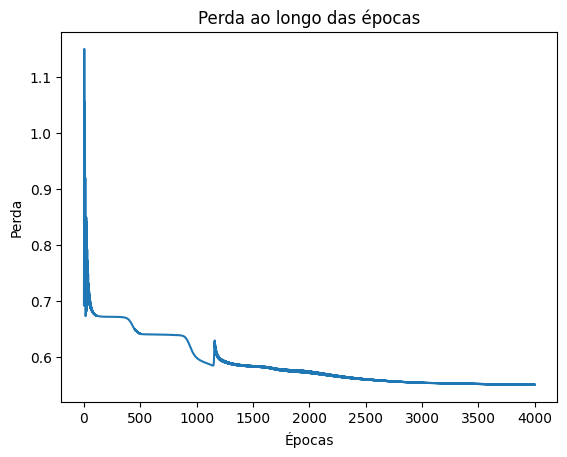

In [17]:
# Criação da Rede Neural de Classificação Binária: entrada_tamanho, oculto_tamanho, saida_tamanho, taxa_aprendizado=0.01:
rede_Class_Binaria = ClassificacaoBinaria(X_treino.shape[1], 10, 1, 0.01)

# Treinamento da Rede Neural
perdas = rede_Class_Binaria.treinar(X_treino, y_treino, epocas=4001)

# Avaliação da Rede Neural
y_predito = rede_Class_Binaria.prever(X_teste)

# Calcula o total de previsões corretas
previsoes_corretas = 0
for yreal, ypred in zip(y_teste, y_predito):
    if yreal == ypred:
        previsoes_corretas += 1

# Calcula a acurácia do modelo
acuracia = previsoes_corretas / len(y_teste)
print("\n:: Acurácia do modelo: {:.4f}".format(acuracia))

# Exibe a curva de perda
plt.plot(perdas)
plt.title("Perda ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.show()